# Generate a mock peculiar velocity catalogue from CSiBORG haloes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from h5py import File
from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM

import csiborgtools

%matplotlib inline
%load_ext autoreload
%autoreload 2

SPEED_OF_LIGHT = 299_792.458 

In [2]:
def dist2redshift(dist, cosmo):
    x = np.linspace(0., 1., int(1e5))
    y = cosmo.comoving_distance(x).value
    return interp1d(y, x, kind="cubic")(dist)

In [3]:
nsim = 17417
nsnap = 99
kind = "main"
cat = csiborgtools.read.CSiBORG2SUBFINDCatalogue(nsim, nsnap, kind)

cosmo = FlatLambdaCDM(H0=100, Om0=0.3111)

In [4]:
dist, RA, dec = [cat["spherical_pos"][:, i] for i in range(3)]
Vx, Vy, Vz = [cat["cartesian_vel"][:, i] for i in range(3)]
vrad = csiborgtools.flow.project_Vext(Vx, Vy, Vz, np.deg2rad(RA), np.deg2rad(dec))
zcosmo = dist2redshift(dist, cosmo)
zobs = (1 + zcosmo) * (1 + vrad / SPEED_OF_LIGHT) - 1

data = {"r_hMpc": dist,
        "RA": RA,
        "DEC": dec,
        "vrad": vrad,
        "zcosmo": zcosmo,
        "zobs": zobs}

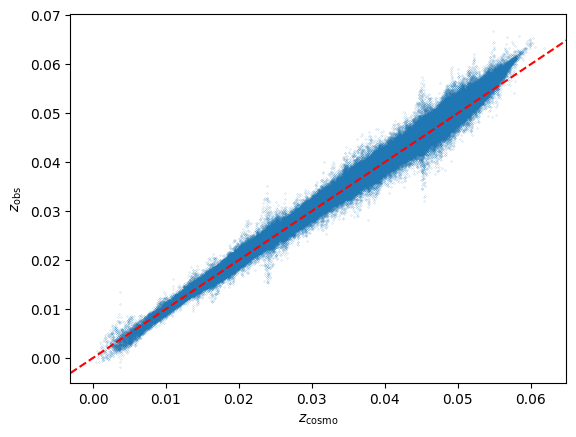

In [5]:
plt.figure()
plt.scatter(zcosmo, zobs, s=0.01)

plt.axline((0, 0), slope=1, color="red", linestyle="--")
plt.xlabel(r"$z_{\rm cosmo}$")
plt.ylabel(r"$z_{\rm obs}$")

plt.show()

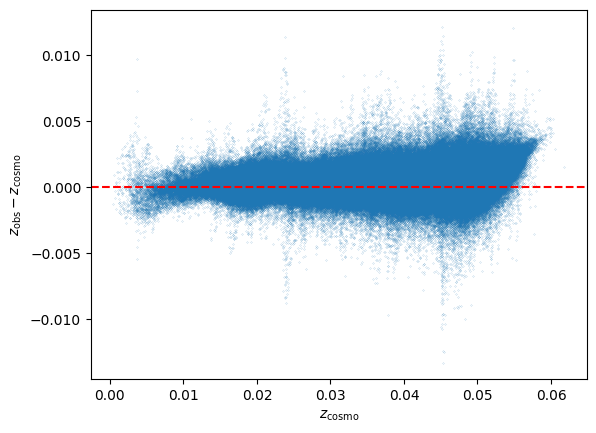

In [6]:
plt.figure()
plt.scatter(zcosmo, zobs - zcosmo, s=0.01)

plt.axhline(0, color="red", linestyle="--")
plt.xlabel(r"$z_{\rm cosmo}$")
plt.ylabel(r"$z_{\rm obs} - z_{\rm cosmo}$")

plt.show()

In [7]:
mask = (cat["totmass"] > 5e12) & (cat["totmass"] < 1e13) & cat["Central"] & (cat["dist"] < 135.5)

In [10]:
choice = np.random.choice(np.arange(len(cat))[mask], size=100)

In [11]:
fname = f"/mnt/extraspace/rstiskalek/catalogs/PV_mock_CB2_{nsim}_small.hdf5"
with File(fname, "w") as f:
    for key, value in data.items():
        f.create_dataset(key, data=value[choice])